# What truly influences demand and sales for Walmart?

## Contribution Details:

Contribution Checkpoints:

A: Project idea - 5%

B: Dataset Curation and Preprocessing - 10%

C: Data Exploration and Summary Statistics - 10%

D: ML Algorithm Design/Development - 25%

E: ML Algorithm Training and Test Data Analysis - 20%

F: Visualization, Result Analysis, Conclusion - 15%

G: Final Tutorial Report Creation - 10%

H: Additional (not listed above, if any) - 5%

**Member 1: Christopher Perez Lebron**, Contribution: 100%

**Member 2: Ever Campos**, Contribution: 100%

**Member 3: Abbas Islaw**, Contribution: 100%

"We, all team members, agree together that the above information is true, and we are confident about our contributions to this submitted project/final tutorial."

**Christopher Perez Lebron, 5/7/24**

**Ever Campos, 5/7/24**

**Abbas Islaw, 5/7/24**

## Contribution Details, Continued:

Christopher Perez Lebron:

Ever Campos:

Abbas Islaw

## Spring 2024 Data Science Project

*Christopher Perez Lebron, Ever Campos, Abbas Islaw*

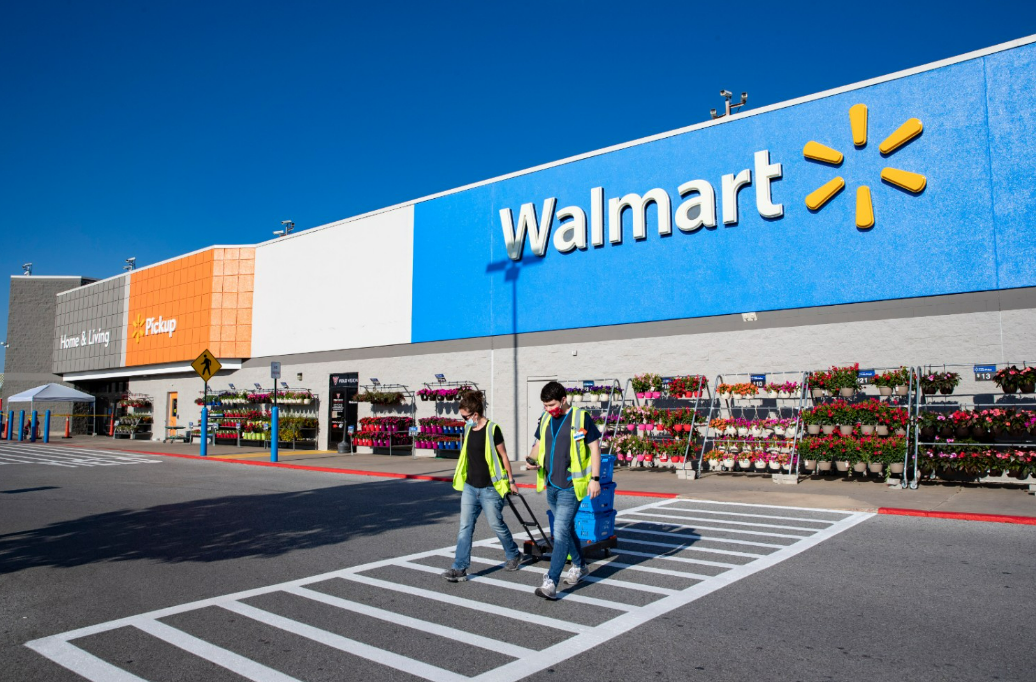

Demand. It's the heart of business. Virtually everyone in the business world is curious to find out the answer to a simple question - what is influencing demand for a particular product? For Walmart, a multinational corporation that has hundreds - if not thousands - of different products, it can be complicated to find out what factors are driving demand at a store-wide scale. 

Is it the selection of products themselves? 

Could it be the status of the economy? 

These questions are simple, yet hard to pinpoint.

We were particularly curious to find out what drives the demand and values of weekly sales for a large corporation such as Walmart. We wanted to dig deep and figure out the factors influencing weekly sales - and possibly predict weekly sales of different stores around the world.

# Data Curation / Importing Data

For our data, we decided to use a dataset from Kaggle, "Walmart Sales":
https://www.kaggle.com/datasets/mikhail1681/walmart-sales

This dataset has thousands of datapoints of different Walmart stores during different timepoints, including their weekly sales, current Consumer Price Index (CPI), fuel prices, holiday weeks, and more.

Imports needed:

In [272]:
import pandas as pd
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
import datetime as dt
import math

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LearningCurveDisplay, learning_curve

from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score
from scipy.ndimage import gaussian_filter1d 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Let's take a quick look at our data:

In [273]:
df = pd.read_csv("Walmart_sales.csv")
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


## Data Cleaning 

Moreover, let's convert the date column into datetime:


In [274]:
df["Date"] = pd.to_datetime(df['Date'], format="%d-%m-%Y")

print(df.dtypes)
df.head()

Store                    int64
Date            datetime64[ns]
Weekly_Sales           float64
Holiday_Flag             int64
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
dtype: object


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


# Exploratory Data Analysis

## Individual Feature Exploration

### Stores

#### Taking a look at the number of stores

In [275]:
numStores = len(df["Store"].unique())
print("Number of Stores: " + str(numStores))

Number of Stores: 45


Clearly, we have a pretty large number of stores (around 10% of the stores in the US according to some quick research). 

#### Taking a look at the number of holidays per store 

Axes(0.125,0.11;0.775x0.77)


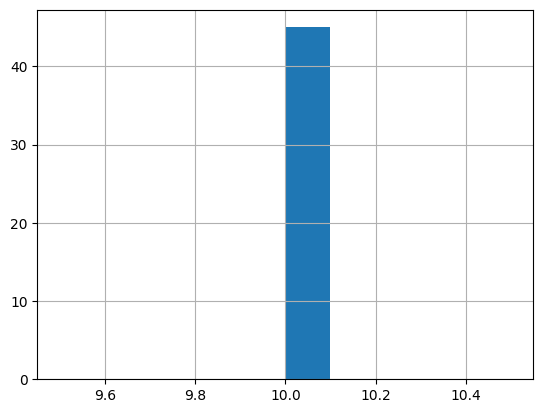

In [276]:
print(df[df["Holiday_Flag"] == 1].groupby("Store")["Holiday_Flag"].count().hist())

It looks like each store has exactly 10 holidays.

#### Taking a look at the average sales per store

<Axes: >

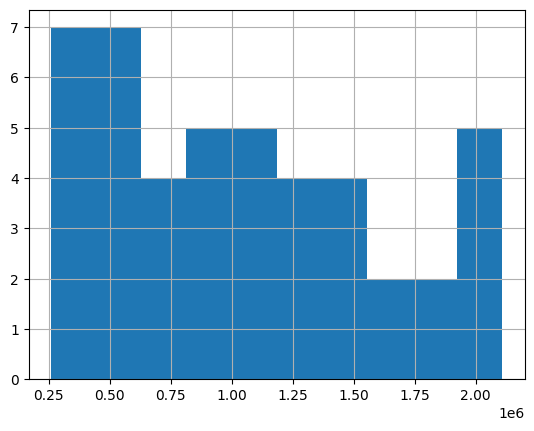

In [277]:
# Average sales per store differs 
df.groupby("Store")["Weekly_Sales"].mean().hist()

It seems like the average sales per store varies.

#### Taking a look at average temperature per store 

<Axes: >

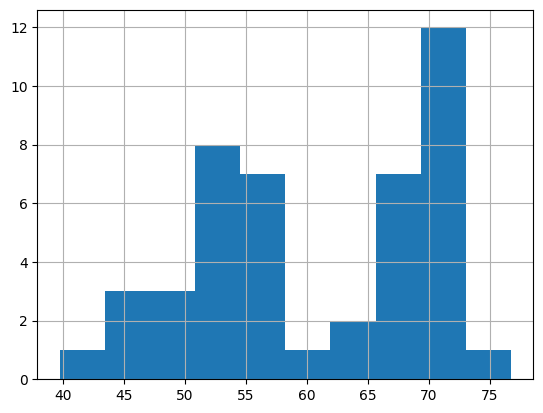

In [278]:
df.groupby("Store")["Temperature"].mean().hist()

The distribution of average temperature per store is bimodal with a peak around 52 degrees and another peak around 70 degrees. 

It seems like the stores are in different regions and/or that the dates for each store span different time frames. 

Spoiler alert: when you take a look at average CPI per store it becomes clear that there is a temporal difference between stores. However, the geographic difference cannot be asserted. 

#### Taking a look at the average CPI per store 

<Axes: >

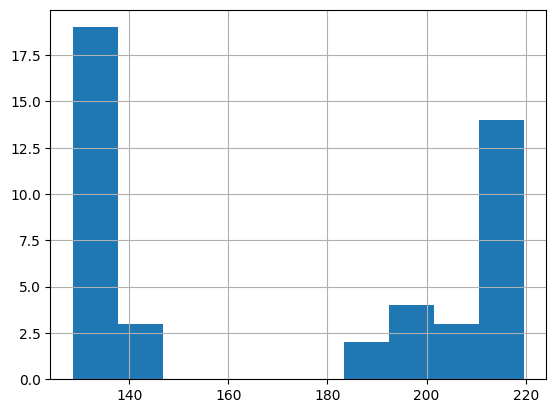

In [279]:
df.groupby("Store")["CPI"].mean().hist()

This supports the assertion that the stores come from different moments in time because CPI is fixed for each day. Thus, if the stores were all overlapping in time we'd see the same average for every store.

#### Taking a look at the average unemployment rate per store

<Axes: >

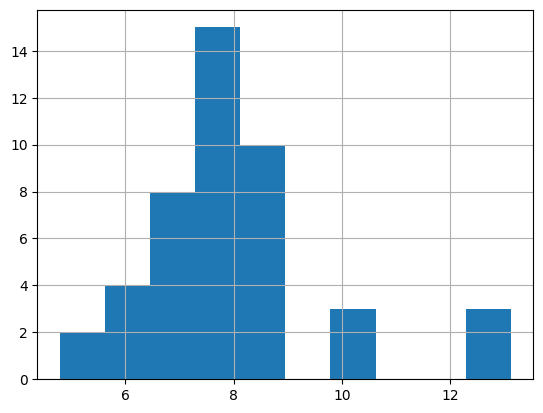

In [280]:
df.groupby("Store")["Unemployment"].mean().hist()

This once again supports the assertion that the data from these stores don't come from the same period of time. 

However, it is weird that the average unemployment rate per store and the avg CPI per store don't follow a similar distribution. This might be worth exploring.

#### Summary of findings after exploring the Store column

##### Observed
- Stores aren't aligned in time. That is, the dates of their sales data differ. 
- Average sales per store differ. Different levels of performance. 
- Every store has the same number of holidays.
- There are 45 stores.

##### Questions
- Are the stores in different regions?
- Why is the distribution of average unemployment rates different from the distribution of average CPI? 
    - Is unemployment rate local or national? 

### Date

The number of unique dates are: 143


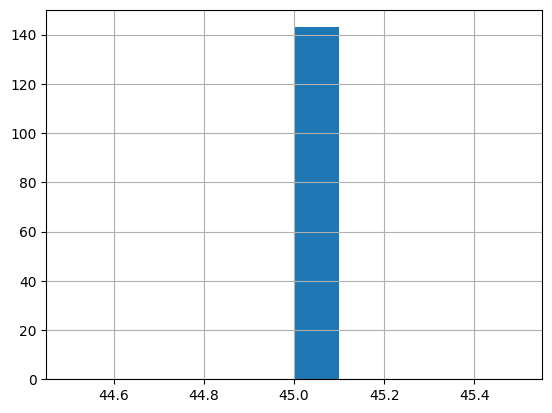

In [281]:
df.groupby("Date")["Date"].count().hist()
numUnique = len(df["Date"].unique())
print("The number of unique dates are: " + str(numUnique))

So we have 143 unique dates w/ each date having 45 corresponding instances.

<Axes: xlabel='Date'>

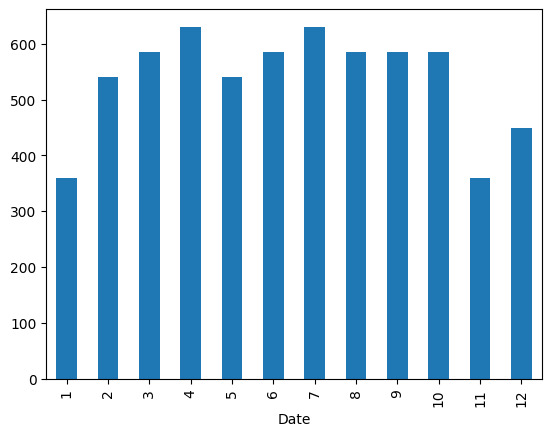

In [282]:
df.groupby(df["Date"].dt.month)["Date"].count().plot(kind="bar")

We do not have the same amount of data for each month of the year. So this again, supports the assertion that the data for each store is not set in the same time frame.

Now, lets take a look at the amount of data we have for each year.

<Axes: xlabel='Date'>

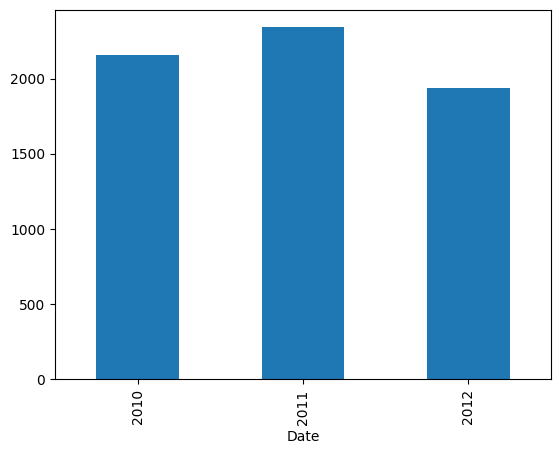

In [283]:
df.groupby(df["Date"].dt.year)["Date"].count().plot(kind="bar")

We have the most data on sales during 2011, then sales in 2010, and last sales in 2012.

### Weekly Sales

Mean: 1046964.8775617715
Std Dev: 564366.6220536975


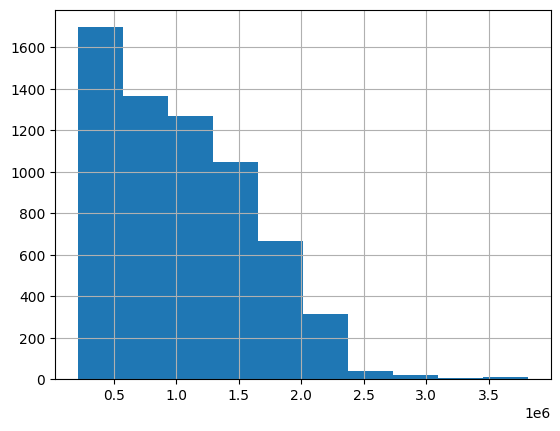

In [284]:
df["Weekly_Sales"].hist()
mean = df["Weekly_Sales"].mean()
stdDev = df["Weekly_Sales"].std()

print("Mean: " + str(mean))
print("Std Dev: " + str(stdDev))

This is a really weird distribution... why is the distribution this way? Does this have to do with how the sales data was collected, with the way walmart operates it's stores, or some other factor we cannot think of?

### Holiday Flag

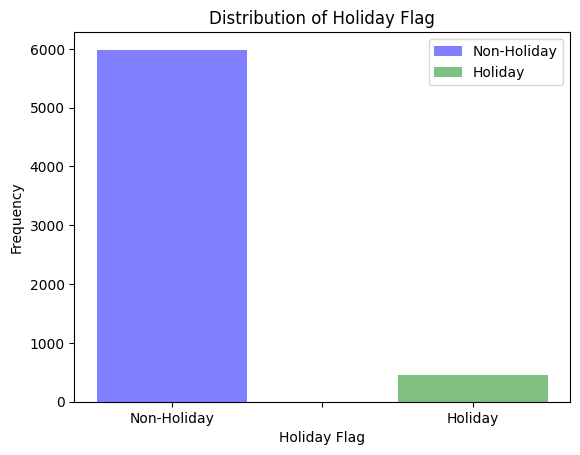

In [285]:
# Define the bin edges to align with tick marks
bins = [-0.25, 0.25, 0.75, 1.25]

non_holiday = df[df['Holiday_Flag'] == 0]
holiday = df[df['Holiday_Flag'] == 1]

plt.hist(non_holiday['Holiday_Flag'], bins=bins, color='blue', label='Non-Holiday', alpha=0.5)
plt.hist(holiday['Holiday_Flag'], bins=bins, color='green', label='Holiday', alpha=0.5)

plt.xlabel('Holiday Flag')
plt.ylabel('Frequency')
plt.title('Distribution of Holiday Flag')
plt.legend()

# Customizing x-axis ticks and labels
plt.xticks([0, 0.5, 1], ['Non-Holiday', '', 'Holiday'])

plt.show()

From this analysis, we can infer that there is a very low percentage of weeks that are holidays. Consequently, holiday weeks, defined as 1, are expected to have a smaller effect on sales compared to holiday weeks. As, their lower holiday weeks vs. vs. holiday weeks in general, will be taking a look at the relationship between holidays and sales further below for stotres 1 - 4.

### Temperature

count    6435.000000
mean       60.663782
std        18.444933
min        -2.060000
25%        47.460000
50%        62.670000
75%        74.940000
max       100.140000
Name: Temperature, dtype: float64


<Axes: >

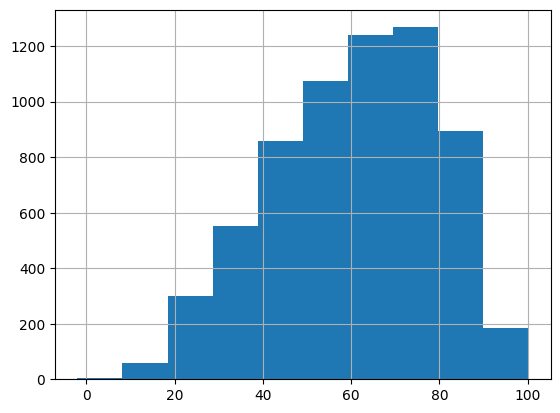

In [286]:
print(df["Temperature"].describe())
df["Temperature"].hist()

There is a large variation in temperatures. This could mean one of three things: 
- The stores are in different geographic locations. 
- All the stores are not in different geograhic locations but rather they are all located in a region that sees both temperature extremes a year.
- **Climate change** 

### Fuel Price

<Axes: >

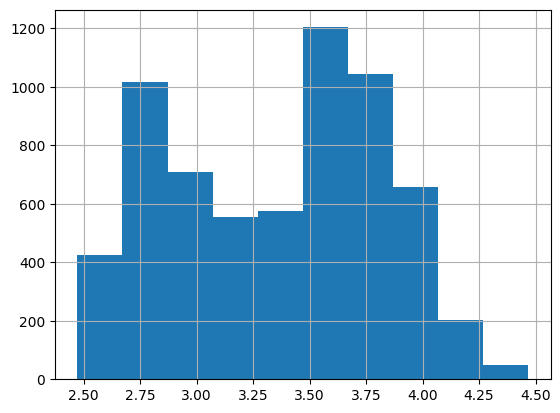

In [287]:
# View histogram for fuel price
df['Fuel_Price'].hist()

We have a bimodal distribution for our fuel prices.

In [288]:
# View summary statistics
mean = df['Fuel_Price'].mean()
stdDev = df['Fuel_Price'].std()

print(f"Mean: {mean}")
print(f"Standard Devation: {stdDev}")

Mean: 3.358606837606838
Standard Devation: 0.4590197071928525


In today's dollars adjusted for inflation that would be a mean gas price of about $4.70. This unusually high average may affect the generalizability of our ML model / conclusions

### Consumer Price Index

<Axes: >

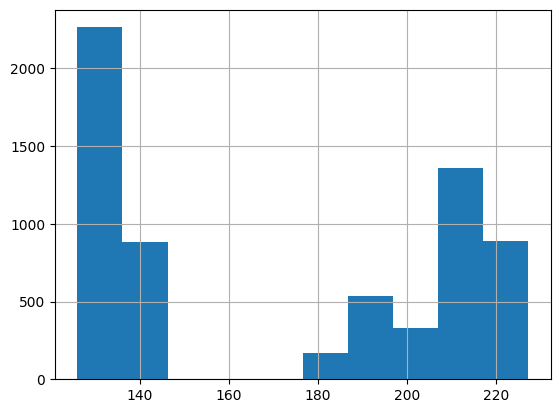

In [289]:
# View histogram
df['CPI'].hist()

It looks like we have a really weird discrete set of values. I wonder why there seems to be a chunk missing. From my understanding CPI is a continuous index that doesn't simply jump out like that. 

To dig deeper into why this occured let's look at CPI for each store (it should be roughly the same because the data is from the same time frame but it help determine the cause).  

<Axes: >

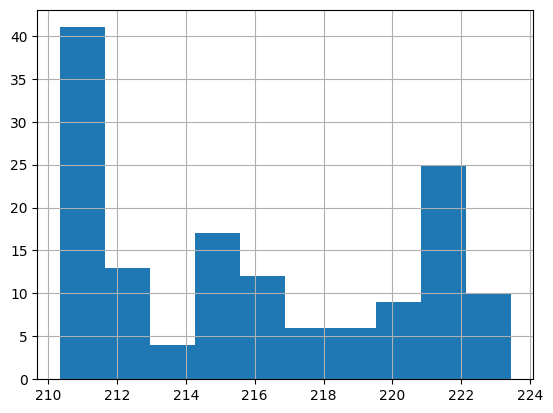

In [290]:
# Histogram for store 1
df[df['Store'] == 1]['CPI'].hist()

In [291]:
frame = df[df['Store'] == 1]['CPI']
print(f"Range: [{frame.min()}, {frame.max()}]")

Range: [210.3374261, 223.4442513]


It looks store 1 is continuous in the rough range [210, 223].

<Axes: >

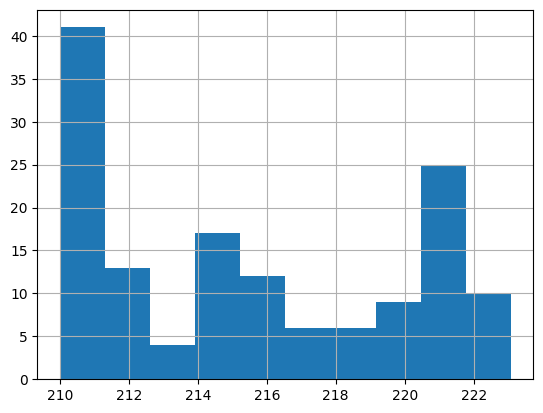

In [292]:
# View histogram of cpi for store 2
df[df['Store'] == 2]['CPI'].hist()

In [293]:
frame = df[df['Store'] == 2]['CPI']
print(f"Range: [{frame.min()}, {frame.max()}]")

Range: [209.9984585, 223.0783366]


Store 2's CPI values seem to be continuous in a very similar range as store 1.

<Axes: >

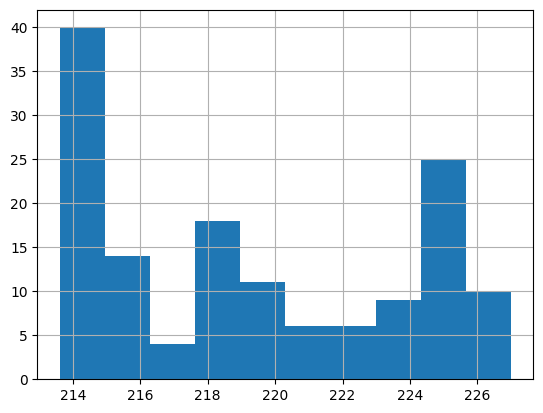

In [294]:
# View histogram of CPI's for store 3
df[df['Store'] == 3]['CPI'].hist()

In [295]:
frame = df[df['Store'] == 3]['CPI']
print(f"Range: [{frame.min()}, {frame.max()}]")

Range: [213.6196139, 226.9873637]


Again, very similar range of CPI values. So, stores 1, 2, and 3 all have similar CPI ranges and store 4 seems to be an outlier in the CPI data.

<Axes: >

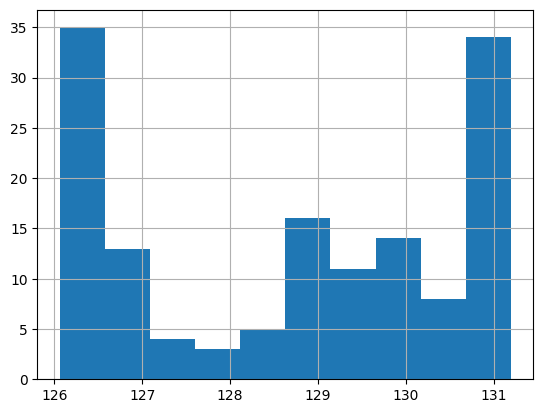

In [296]:
# View histogram of CPI values for store 4
df[df['Store'] == 4]['CPI'].hist()

In [297]:
frame = df[df['Store'] == 4]['CPI']
print(f"Range: [{frame.min()}, {frame.max()}]")

Range: [126.064, 131.1930968]


As suspected, store 4 is completely misasligned with the other stores in terms of it's CPI values. Hence, why we had that huge gap in data in the histogram of ALL CPI values. 

### Unemployment

Avg unemployment rate: 7.99915104895105


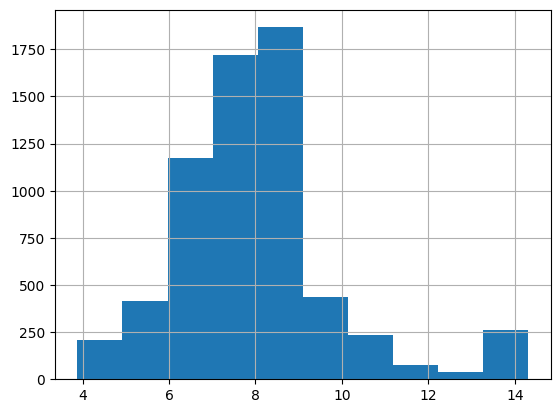

In [298]:
df['Unemployment'].hist()

print("Avg unemployment rate: " + str(df["Unemployment"].mean()))

It looks like we have relatively high unemployment rates throughout most of our data. This is an important attribute to note as it may affect the generalizability of our ML Model and/or conclusions.

## Feature vs Sales

### Tempature vs Sales

We want to use a hypothesis test to figure out whether temperature affects sales.

*Null Hypothesis*: The average temperature of the area has no effect on the sales.

*Alternative Hypothesis*: The average temperature of the area does have an effect on the sales.

Assume that we have a significance level of 0.05.

First, let's plot the stores, with their respective average temperature and weekly sales. We'll use a scatter plot, with each dot being a store from the set.

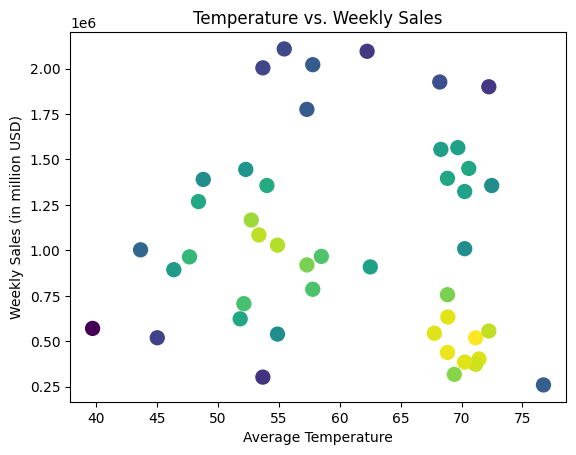

In [299]:
store_avgs = df.groupby("Store").mean("Temperature")

temp = store_avgs["Temperature"]
sales = store_avgs["Weekly_Sales"]

ts = np.vstack([temp,sales])
z = sci.stats.gaussian_kde(ts)(ts)

fig, plot = plt.subplots()

plt.title("Temperature vs. Weekly Sales")
plt.xlabel("Average Temperature")
plt.ylabel("Weekly Sales (in million USD)")

plot.scatter(temp, sales, c=z, s=100)

plt.show()

We can see that the stores are scattered around pretty evenly, with small clusters around the average temperature of 45-55 and 65-75 degree range.

Let's check the correlation between the two variables.

In [300]:
result = sci.stats.pearsonr(store_avgs["Temperature"], store_avgs["Weekly_Sales"], alternative="two-sided")

print(result)

PearsonRResult(statistic=-0.07638774908646385, pvalue=0.6179663423198961)


Notice that the pearson correlation coefficient is -0.076, meaning that it is slightly negative. This means that as the average temperature increases, then the weekly sales decrease. Since the p value is larger than our alpha value (0.617), we fail to reject the null hypothesis. In other words, we can see that the average temperature does not have an effect on weekly sales.

### Fuel Price vs Sales

We can also use a hypothesis test to check if fuel prices have an effect on sales.

*Null Hypothesis: Fuel Prices do not have any effect on weekly sales.*

*Alternative Hypothesis: Fuel prices do have an effect on weekly sales.*

Assume the significance level as 0.05.

Let's first create a scatter plot graphing the correlation between fuel price and weekly sales.

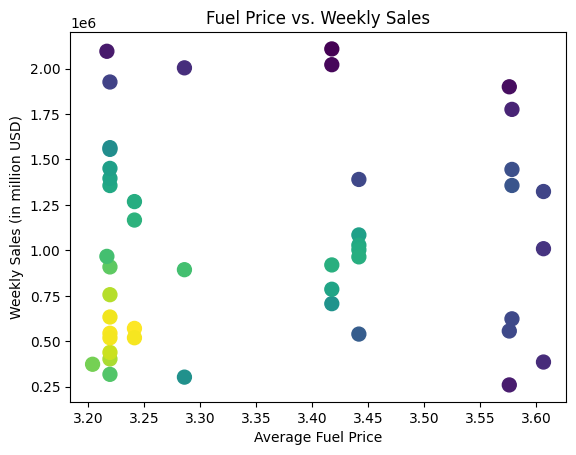

In [301]:
store_avgs = df.groupby("Store").mean("Fuel_Price")

temp = store_avgs["Fuel_Price"]
sales = store_avgs["Weekly_Sales"]

ts = np.vstack([temp,sales])
z = sci.stats.gaussian_kde(ts)(ts)

fig, plot = plt.subplots()

plt.title("Fuel Price vs. Weekly Sales")
plt.xlabel("Average Fuel Price")
plt.ylabel("Weekly Sales (in million USD)")

plot.scatter(temp, sales, c=z, s=100)

plt.show()

The fuel prices seem divided into three categories of prices, ranging from 3.20, 3.45, and 3.6 USD per gallon. With those three subdivisions, we can see that the weekly sales seem evenly spread out. From inspection, there looks like there's a very, VERY slight downard trend when the fuel price goes up.

Let's run a pearson correlation coefficient test to find out the correlation:

In [302]:
result = sci.stats.pearsonr(store_avgs["Fuel_Price"], store_avgs["Weekly_Sales"], alternative="two-sided")

print(result)

PearsonRResult(statistic=0.06773422508957694, pvalue=0.6584189067151822)


Notice that the correlation coefficient is 0.06, which is slightly positive. As fuel prices go up, so do weekly sales. However, this is a very, very small increase, to the point where it isn't significant enough.

Since our p value is 0.65, which is way higher than our alpha value of 0.05, we fail to reject the null hypothesis. In other words, fuel price does not have an effect on weekly sales.

### CPI vs Sales

We want to use a hypothesis test to figure out whether cpi affects sales.

*Null Hypothesis*: The average cpi does no effect on the sales.

*Alternative Hypothesis*: The average cpi does have an effect on the sales.

Assume that we have a significance level of 0.05.

First, let's plot the stores, with their respective average cpi and weekly sales. We'll use a scatter plot, with each dot being a store from the set.

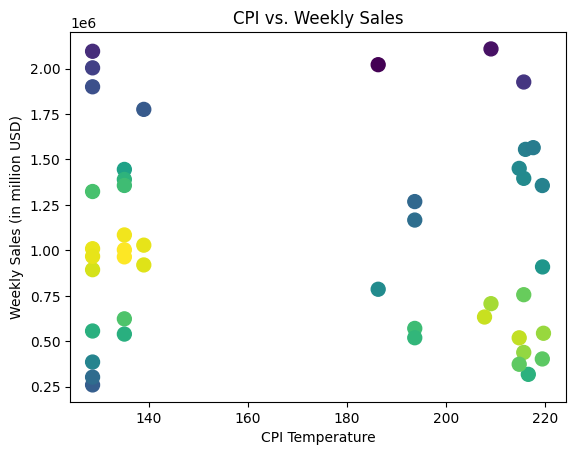

In [303]:
store_avgs = df.groupby("Store").mean("CPI")

temp = store_avgs["CPI"]
sales = store_avgs["Weekly_Sales"]

ts = np.vstack([temp,sales])
z = sci.stats.gaussian_kde(ts)(ts)

fig, plot = plt.subplots()

plt.title("CPI vs. Weekly Sales")
plt.xlabel("CPI Temperature")
plt.ylabel("Weekly Sales (in million USD)")

plot.scatter(temp, sales, c=z, s=100)

plt.show()

We observe that the stores are divided into two groups: some stores cluster around 140 CPI on the left-hand side, while others cluster around 200 CPI on the right-hand side. Interestingly, there appears to be an even distribution of revenue among these points, indicating comparable sales performance across stores despite differences in CPI.

In [304]:
result = sci.stats.pearsonr(store_avgs["CPI"], store_avgs["Weekly_Sales"], alternative="two-sided")

print(result)

PearsonRResult(statistic=-0.07656886071136423, pvalue=0.6171309899200195)


Notice that the Pearson correlation coefficient is -0.0765, indicating a slight negative correlation. This suggests that as the average CPI increases, weekly sales decrease. However, since the p-value is larger than our alpha value (0.617), we fail to reject the null hypothesis. In other words, we can conclude that the average CPI does not have a significant effect on weekly sales. This conclusion is supported by the scatter plot visualization, where no noticeable change in the relationship between average CPI and weekly sales is observed as CPI increases or decreases.

### Unemployment vs Sales

We want to now test if unemployment rates have an effect on the stores' average weekly sales.

*Null Hypothesis:* The unemployment rate has no effect on the stores' average weekly sales.

*Alternative Hypothesis:* The unemployment rate does have an effect on the stores' average weekly sales.

Assume that our significance level is 0.05.

We can graph a scatter plot of each store:

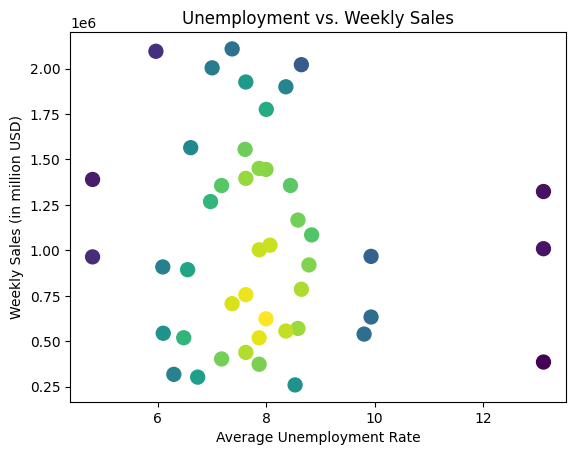

In [305]:
temp = store_avgs["Unemployment"]
sales = store_avgs["Weekly_Sales"]

ts = np.vstack([temp,sales])
z = sci.stats.gaussian_kde(ts)(ts)

fig, plot = plt.subplots()

plt.title("Unemployment vs. Weekly Sales")
plt.xlabel("Average Unemployment Rate")
plt.ylabel("Weekly Sales (in million USD)")

plot.scatter(temp, sales, c=z, s=100)

plt.show()

We can see that most of the stores' average unemployment rates are between 6-9 percent, with sales being scattered pretty evenly across the board.

Let's now check the correlation between the two variables:

In [306]:
result = sci.stats.pearsonr(store_avgs["Unemployment"], store_avgs["Weekly_Sales"], alternative="two-sided")

print(result)

PearsonRResult(statistic=-0.11228079769921509, pvalue=0.4627451284572275)


Notice that the correlation coefficient is -0.112, which is slightly negative. This means that as unemployment rates go up, the weekly sales will go slighly down. Since our p value is 0.46, which is greater than 0.05, we fail to reject the null hypothesis. In other words, the unemployment rate does not have an effect on weekly sales.

### Holiday vs Sales

Will be taking a look at the relationship between holidays and sales for stores 1 through 4, as we know from the Holiday flag, there is lower frequency of holiday weeks then non-holiday weeks.

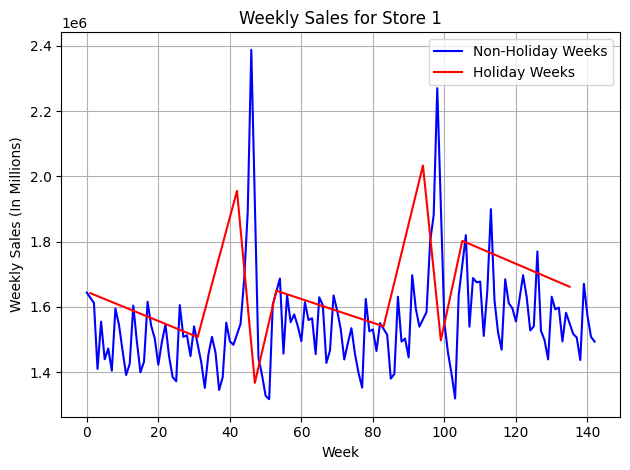

In [307]:
# Store 3 with non-Holiday's
non_holiday_1 = df[(df['Store'] == 1) & (df['Holiday_Flag'] == 0)].iloc[:140]

# Store 4 with holidays
holiday_1 = df[(df['Store'] == 1) & (df['Holiday_Flag'] == 1)].iloc[:140]


# Plot sales data for Store 1 during non-holiday weeks
plt.plot(non_holiday_1.index, non_holiday_1['Weekly_Sales'], color='blue', label='Non-Holiday Weeks')

# Plot sales data for Store 1 during holiday weeks
plt.plot(holiday_1.index, holiday_1['Weekly_Sales'], color='red', label='Holiday Weeks')

plt.xlabel('Week')
plt.ylabel('Weekly Sales (In Millions)')
plt.title('Weekly Sales for Store 1')
plt.legend()
plt.grid(True)  
plt.tight_layout()
plt.show()

The interaction between the sales data during non-holiday and holiday weeks highlights the impact of holidays on consumer behavior and sales activity for Store 1, providing valuable insights for strategic decision-making in retail management

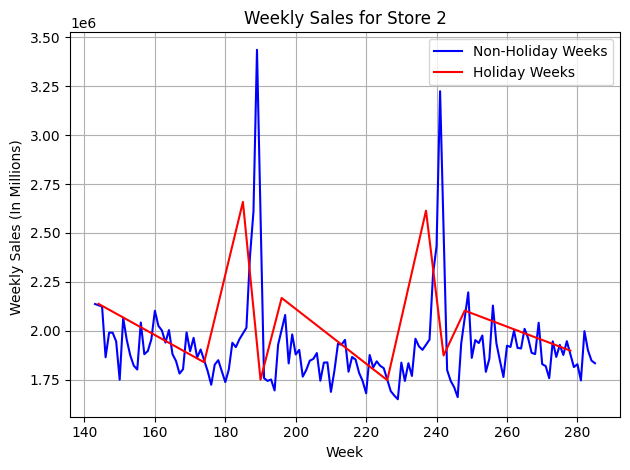

In [308]:
# Store 3 with non-Holiday's
non_holiday_2 = df[(df['Store'] == 2) & (df['Holiday_Flag'] == 0)].iloc[:140]

# Store 4 with holidays
holiday_2 = df[(df['Store'] == 2) & (df['Holiday_Flag'] == 1)].iloc[:140]


# Plot sales data for Store 1 during non-holiday weeks
plt.plot(non_holiday_2.index, non_holiday_2['Weekly_Sales'], color='blue', label='Non-Holiday Weeks')

# Plot sales data for Store 1 during holiday weeks
plt.plot(holiday_2.index, holiday_2['Weekly_Sales'], color='red', label='Holiday Weeks')

plt.xlabel('Week')
plt.ylabel('Weekly Sales (In Millions) ')
plt.title('Weekly Sales for Store 2')
plt.legend()
plt.grid(True)  
plt.tight_layout()
plt.show()

In the second store, we notice that there is a significant difference in the total sales amount compared to store 1, which is much higher.

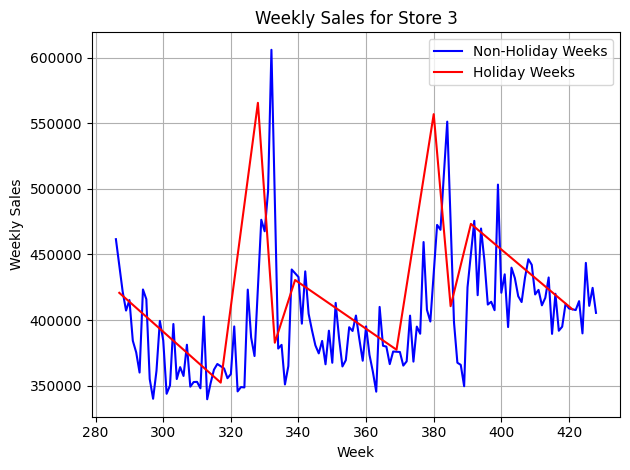

In [309]:
# Store 3 with non-Holiday's
non_holiday_3 = df[(df['Store'] == 3) & (df['Holiday_Flag'] == 0)].iloc[:140]

# Store 4 with holidays
holiday_3 = df[(df['Store'] == 3) & (df['Holiday_Flag'] == 1)].iloc[:140]


# Plot sales data for Store 1 during non-holiday weeks
plt.plot(non_holiday_3.index, non_holiday_3['Weekly_Sales'], color='blue', label='Non-Holiday Weeks')

# Plot sales data for Store 1 during holiday weeks
plt.plot(holiday_3.index, holiday_3['Weekly_Sales'], color='red', label='Holiday Weeks')

plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales for Store 3')
plt.legend()
plt.grid(True)  
plt.tight_layout()
plt.show()

Store 3 consistently reports among the lowest weekly sales figures compared to other stores. Despite occasional spikes during holidays, its sales performance falls significantly short of Stores 1 and 2, which achieve over 3 million and approximately 550k in total sales, respectively.

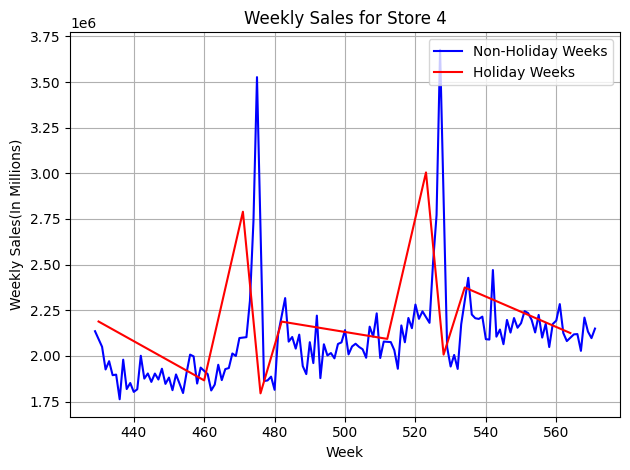

In [310]:
# Store 4 with non-Holidays
non_holiday_4 = df[(df['Store'] == 4) & (df['Holiday_Flag'] == 0)].iloc[:140]

# Store 4 with Holidays
holiday__4 = df[(df['Store'] == 4) & (df['Holiday_Flag'] == 1)].iloc[:140]

plt.plot(non_holiday_4.index, non_holiday_4['Weekly_Sales'], color='blue', label='Non-Holiday Weeks')

plt.plot(holiday__4.index, holiday__4['Weekly_Sales'], color='red', label='Holiday Weeks')

plt.xlabel('Week')
plt.ylabel('Weekly Sales(In Millions)')
plt.title('Weekly Sales for Store 4')
plt.legend()
plt.grid(True)  
plt.tight_layout()
plt.show()

Store 4 demonstrates consistent sales performance akin to that of Store 1 and Store 2. This observation suggests that Stores 1, 2, and 4 likely cater to a comparable population size and exhibit similar consumer foot traffic patterns, in contrast to Store 3.

Thus, from our analysis of stores 1 through 4, there is a similar spike in sales during holiday weeks, as shown from the visualization. This indicates that these stores will have higher revenue and a greater number of consumers visiting during these holiday weeks. Therefore, during these holiday weeks, these stores should continue to prioritize them since this is when they have the greatest revenue.

Moreover, to confirm this, we can create a hypothesis test.

*Null Hypothesis: Holiday weeks don't have an effect on weekly sales.*

*Alternative Hypothesis: Holiday weeks do have an effect on weekly sales.*

Assume our alpha level is 0.05.

We can use a t test to determine if the means of sales during holiday weeks vs. non-holiday weeks are different:

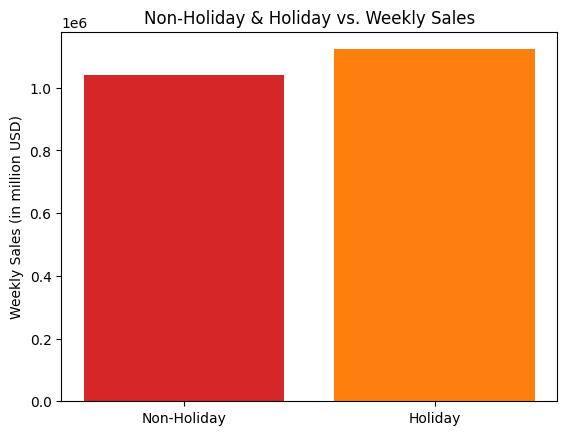

In [311]:
holiday_diff = df.groupby("Holiday_Flag").mean("Weekly_Sales")

fig, ax = plt.subplots()

divisions = ["Non-Holiday", "Holiday"]
counts = [holiday_diff["Weekly_Sales"][0], holiday_diff["Weekly_Sales"][1]]

ax.bar(divisions, counts, color=["tab:red", "tab:orange"])

ax.set_ylabel("Weekly Sales (in million USD)")
ax.set_title("Non-Holiday & Holiday vs. Weekly Sales")

plt.show()

Now, let's run the t test to see if the differences in results are statistically significant:

In [312]:
holiday = df[df["Holiday_Flag"] == 1]["Weekly_Sales"]
no_holiday = df[df["Holiday_Flag"] == 0]["Weekly_Sales"]

result = sci.stats.ttest_ind(holiday, no_holiday)

print(result)

Ttest_indResult(statistic=2.9608919093259036, pvalue=0.003078699263818616)


Notice that our p value is 0.003, which is way lower than the alpha level of 0.05. Through this, we can reject the null hypothesis, meaning that holiday weeks do have an effect on weekly sales! We can also see the differences in the weekly sales for holidays vs. non-holiday weeks in the bar graph above.

#### Month vs. Sales

We can use a hypothesis test to figure out if the month affects the weekly sales *per store*. Note how it wouldn't make sense if we combined stores' weekly sales for each month, because some stores do way better in general than others. If we did do that, then we wouldn't be able to see the differences in month for a particular store.

*Null Hypothesis: The month of the year does not have an effect on weekly sales.*

*Alternative Hypothesis: The month of the year does have an effect on weekly sales.*

Assume a significance level of 0.05.

First of all, let's draw a graph noting the average weekly sales for each month for Store 1:

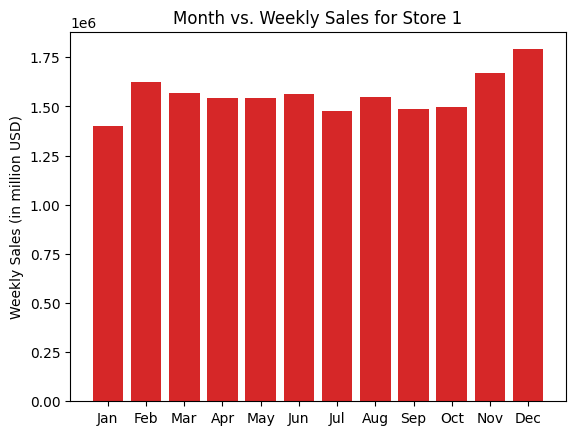

In [313]:
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

def determine_month(date):
    return months[date.month-1]

df["Month"] = df["Date"].apply(determine_month)

def avg(lst):
    return sum(lst) / len(lst)

fig, ax = plt.subplots()

list_of_months = [[],[],[],[],[],[],[],[],[],[],[],[]]

for index in range(len(months)):
    curr_month = []
    for ind, item in df[(df["Month"] == months[index]) & (df["Store"] == 1)].iterrows():
        curr_month.append(float(item["Weekly_Sales"]))
    list_of_months[index] = avg(curr_month)

divisions = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
counts = list_of_months

ax.bar(divisions, counts, color=["tab:red"])

ax.set_ylabel("Weekly Sales (in million USD)")
ax.set_title("Month vs. Weekly Sales for Store 1")

plt.show()

Note that Store 1 seems to be doing way better in sales during the months of November, December, and February. For every other month, it seems to be doing roughly the same numbers (around 1.5 million USD)

Now, let's conduct ANOVA tests for every store.

Note that we want to see if there exists a difference in the means of weekly sales for each month *for each store*:

In [314]:
p_value_results = []

def anova_test(store):

    january = []
    february = []
    march = []
    april = []
    may = []
    june = []
    july = []
    august = []
    september = []
    october = []
    november = []
    december = []

    list_of_months = [january, february, march, april, may, june, july, august, september, october, november, december]

    for index in range(len(months)):
        for ind, item in df[(df["Month"] == months[index]) & (df["Store"] == store)].iterrows():
            list_of_months[index].append(float(item["Weekly_Sales"]))

    result = sci.stats.f_oneway(january, february, march, april, may, june, july, august, september, october, november, december)
    
    print("Store " + str(store) + " test pvalue: " + str(result.pvalue))
    p_value_results.append(result.pvalue)

for num in range(1, 46):
    anova_test(num)

Store 1 test pvalue: 2.7724825133205463e-07
Store 2 test pvalue: 4.330415081536038e-12
Store 3 test pvalue: 2.3031287514697588e-11
Store 4 test pvalue: 5.044527323318062e-08
Store 5 test pvalue: 3.281519930519039e-08
Store 6 test pvalue: 3.475224266634057e-14
Store 7 test pvalue: 2.2422407017372865e-16
Store 8 test pvalue: 8.009722452114776e-11
Store 9 test pvalue: 2.4807011905056473e-09
Store 10 test pvalue: 1.5526974366305664e-16
Store 11 test pvalue: 1.628313504395449e-12
Store 12 test pvalue: 1.6336003498407762e-12
Store 13 test pvalue: 8.359846513589073e-11
Store 14 test pvalue: 3.9656955165561375e-08
Store 15 test pvalue: 4.640380261674347e-13
Store 16 test pvalue: 1.2039358996831871e-18
Store 17 test pvalue: 0.00011345095945005678
Store 18 test pvalue: 2.3721149491082532e-11
Store 19 test pvalue: 1.0812412446782531e-10
Store 20 test pvalue: 7.210105978784641e-13
Store 21 test pvalue: 1.7292012536913808e-12
Store 22 test pvalue: 9.50619842442727e-14
Store 23 test pvalue: 7.742627

Some stores (Store 42, 43, 44, etc...) exibit higher p values upon inspection, going up to 0.66, which would allow us to fail to reject the null hypothesis. However, for the most part, most stores exibit very low p values, way lower than our significance level. This would mean that we'd have to reject the null hypothesis. Let's see how many stores had a result lower than 0.05, and those who had a result higher:

In [315]:
num_less = 0
num_more = 0

for value in p_value_results:
    if value <= 0.05:
        num_less = num_less + 1
    elif value > 0.05:
        num_more = num_more + 1

print("Number of stores with p values less than 0.05: " + str(num_less))
print("Number of stores with p values more than 0.05: " + str(num_more))

Number of stores with p values less than 0.05: 40
Number of stores with p values more than 0.05: 5


We can conclude that for the most part, the months of the year do affect the average sales per store.

# Primary Analysis (Model Exploration) and Visualization

## Standardizing Features

In [316]:
# Create a copy of the original df (incase we want the original to do a comparison)
standardizedDf = df.copy()

standardizedDf

from scipy.stats import zscore
standardizedDf['Temperature'] = zscore(standardizedDf['Temperature'])
standardizedDf['Fuel_Price'] = zscore(standardizedDf['Fuel_Price'])
standardizedDf['CPI'] = zscore(standardizedDf['CPI'])
standardizedDf['Unemployment'] = zscore(standardizedDf['Unemployment'])

# What do we do with dates? 
    # If we use them, how do we handle them? 
        # We could do categorical columns for Year, Month, and Week 
    # If we choose not to use them: 
        # Cool, fine, lets see how it performs :)

standardizedDf

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Month
0,1,2010-02-05,1643690.90,0,-0.995136,-1.713800,1.004175,0.056964,February
1,1,2010-02-12,1641957.44,1,-1.201170,-1.766089,1.007880,0.056964,February
2,1,2010-02-19,1611968.17,0,-1.124178,-1.840166,1.009074,0.056964,February
3,1,2010-02-26,1409727.59,0,-0.760907,-1.737766,1.009849,0.056964,February
4,1,2010-03-05,1554806.68,0,-0.767955,-1.598328,1.010624,0.056964,March
...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,0,0.228602,1.390883,0.519270,0.365109,September
6431,45,2012-10-05,733455.07,0,0.229144,1.364738,0.523256,0.356046,October
6432,45,2012-10-12,734464.36,0,-0.335825,1.397419,0.527241,0.356046,October
6433,45,2012-10-19,718125.53,0,-0.227385,1.329879,0.527332,0.356046,October


## Converting Date Into Ordinal

In [317]:
standardizedDf['Date']=standardizedDf['Date'].map(dt.datetime.toordinal)

# Also, remove month column 
standardizedDf = standardizedDf.drop('Month', axis=1)
standardizedDf

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,733808,1643690.90,0,-0.995136,-1.713800,1.004175,0.056964
1,1,733815,1641957.44,1,-1.201170,-1.766089,1.007880,0.056964
2,1,733822,1611968.17,0,-1.124178,-1.840166,1.009074,0.056964
3,1,733829,1409727.59,0,-0.760907,-1.737766,1.009849,0.056964
4,1,733836,1554806.68,0,-0.767955,-1.598328,1.010624,0.056964
...,...,...,...,...,...,...,...,...
6430,45,734774,713173.95,0,0.228602,1.390883,0.519270,0.365109
6431,45,734781,733455.07,0,0.229144,1.364738,0.523256,0.356046
6432,45,734788,734464.36,0,-0.335825,1.397419,0.527241,0.356046
6433,45,734795,718125.53,0,-0.227385,1.329879,0.527332,0.356046


## Comparing Linear Regression, Decision Tree, and Random Forest

In [318]:
# Consider setting aside train, validate, test

# Here, we could show training data set accuracy vs validation set accuracy as we go through training epochs
    # This could help us show overfitting vs underfitting

# Define X and y
y = standardizedDf['Weekly_Sales']
X = standardizedDf.drop('Weekly_Sales', axis=1)

# Get train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Perform k-fold Cross-Validation for each model
k_folds = 5
skf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Decide the best degree for our data
for k in range(3): 

    if k == 0: 
        model = DecisionTreeRegressor()
        score = cross_val_score(model, X_train, y_train, cv=skf, scoring='r2')
        print("Decision Tree Regressor R^2 Val: " + str(score.mean()))
        print("-----------------------------------------------------")
        continue
    if k == 1:
        model = RandomForestRegressor()
        score = cross_val_score(model, X_train, y_train, cv=skf, scoring='r2')
        print("Random Forest Regressor R^2 Val: " + str(score.mean()))
        print("-----------------------------------------------------")
        continue

    model = make_pipeline(PolynomialFeatures(k), LinearRegression())
    score = cross_val_score(model, X_train, y_train, cv=skf, scoring='r2')
    print("Linear Regressor of degree " + str(k) + " R^2 Val: " + str(score.mean()))
    print("-----------------------------------------------------")


Decision Tree Regressor R^2 Val: 0.8828565050792466
-----------------------------------------------------


Random Forest Regressor R^2 Val: 0.9311401682854014
-----------------------------------------------------
Linear Regressor of degree 2 R^2 Val: 0.25047806329282685
-----------------------------------------------------


## Final Model Selection: RandomForestRegressor

**Why?**
- Far better r^2!
- Better at capturing non-linearity in the data

## Optimizing Hyperparameters

### Depth Limit

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:22<00:00,  1.21s/it]


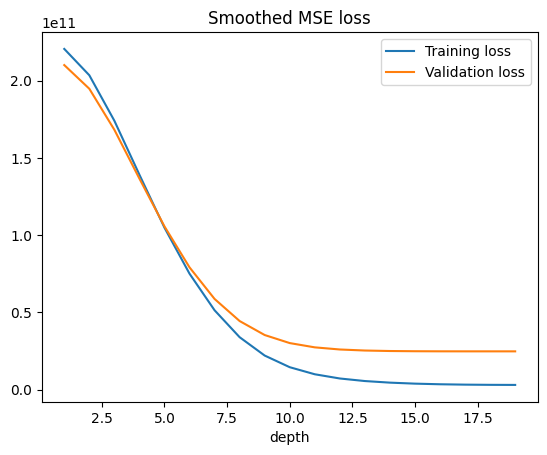

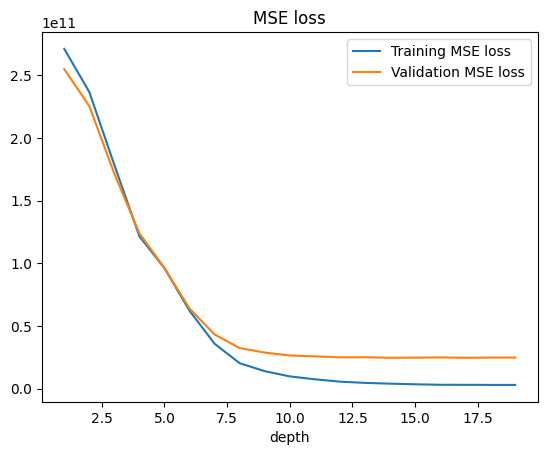

In [319]:
# Split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Split train further to get validation set
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

trainScores = []
validationScores = []
depths = []

for depth in tqdm(range(1, 20)): 
    model = RandomForestRegressor(max_depth= depth)
    model.fit(X_train, y_train)
    trainScores.append(mean_squared_error(y_train,model.predict(X_train)))
    validationScores.append(mean_squared_error(y_validation, model.predict(X_validation)))
    depths.append(depth)

tLossSmooothed = gaussian_filter1d(trainScores, sigma=2)
vLossSmooothed = gaussian_filter1d(validationScores, sigma=2)

plt.plot(depths, tLossSmooothed, label='Training loss')
plt.plot(depths, vLossSmooothed, label='Validation loss')
plt.title(label="Smoothed MSE loss")
plt.xlabel(xlabel="depth")
plt.legend()
plt.show()

plt.plot(depths, trainScores, label='Training MSE loss')
plt.plot(depths, validationScores, label='Validation MSE loss')
plt.title(label="MSE loss")
plt.xlabel(xlabel="depth")
plt.legend()
plt.show()

It seems like the optimal depth limit is around 8 to 12!

### Number of Decision Trees

100%|██████████| 84/84 [05:26<00:00,  3.88s/it]


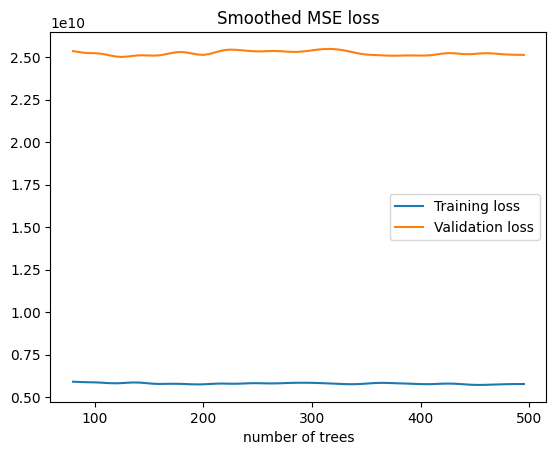

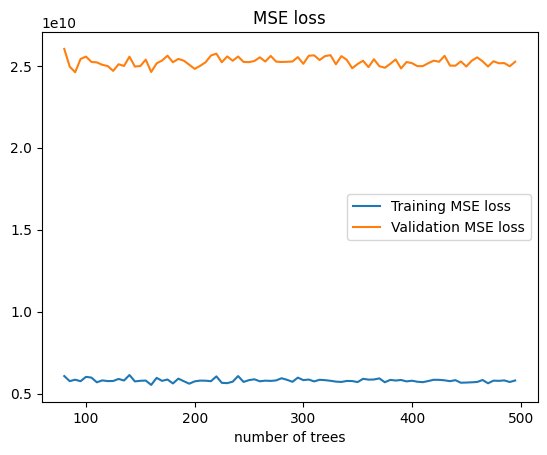

In [320]:
# Fixing depth to 12
depth = 12

trainScores = []
validationScores = []
trees = []

for numTrees in tqdm(range(80, 500, 5)): 
    model = RandomForestRegressor(max_depth= depth, n_estimators=numTrees)
    model.fit(X_train, y_train)
    trainScores.append(mean_squared_error(y_train,model.predict(X_train)))
    validationScores.append(mean_squared_error(y_validation, model.predict(X_validation)))
    trees.append(numTrees)

tLossSmooothed = gaussian_filter1d(trainScores, sigma=2)
vLossSmooothed = gaussian_filter1d(validationScores, sigma=2)

plt.plot(trees, tLossSmooothed, label='Training loss')
plt.plot(trees, vLossSmooothed, label='Validation loss')
plt.title(label="Smoothed MSE loss")
plt.xlabel(xlabel="number of trees")
plt.legend()
plt.show()

plt.plot(trees, trainScores, label='Training MSE loss')
plt.plot(trees, validationScores, label='Validation MSE loss')
plt.title(label="MSE loss")
plt.xlabel(xlabel="number of trees")
plt.legend()
plt.show()

It seems like increasing the number of decision trees doesn't have an appreciable affect on the loss.

## Train Random Forest Model

STATISTICS FOR DEPTH 8
-----------------------------------------
Test MSE: 22620121820.728157
Test sqrt of mse: 150399.87307417567
Test RMSE: 150399.87307417567
Test MAE: 87291.4867427425
Test R² score: 0.9292503553651399


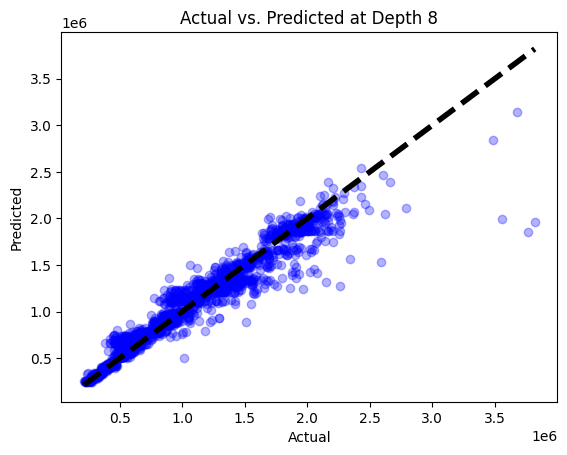

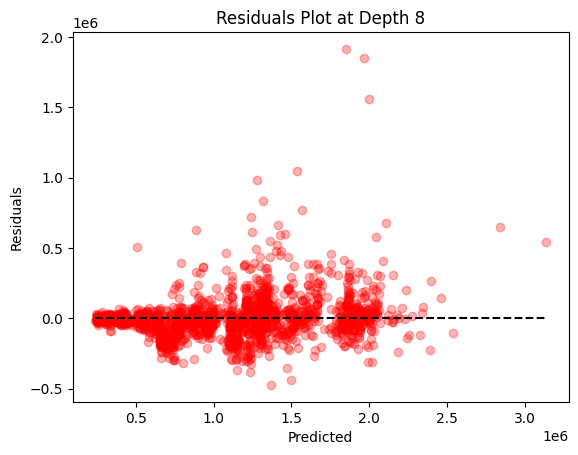

STATISTICS FOR DEPTH 9
-----------------------------------------
Test MSE: 16922934476.706272
Test sqrt of mse: 130088.17961946531
Test RMSE: 130088.17961946531
Test MAE: 71692.63223354517
Test R² score: 0.9470696219103099


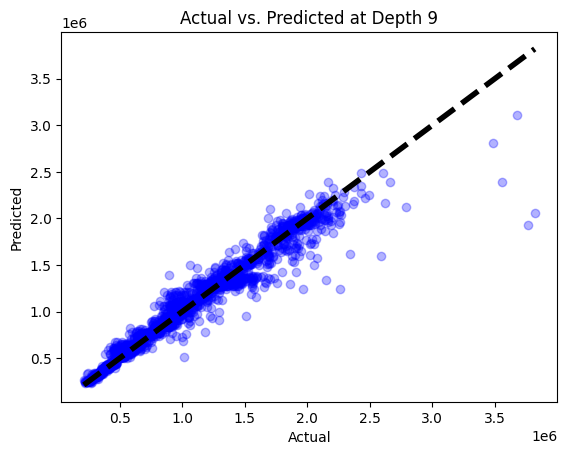

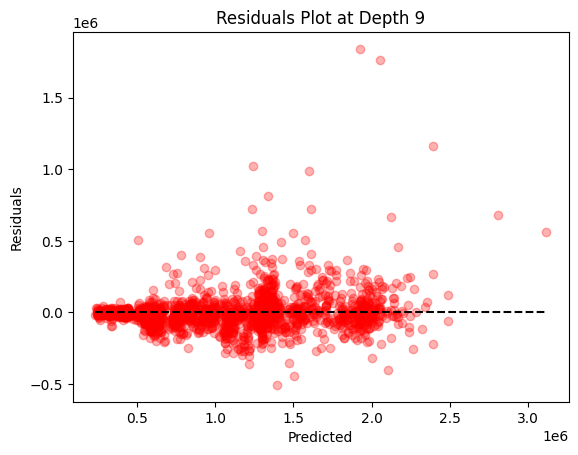

STATISTICS FOR DEPTH 10
-----------------------------------------
Test MSE: 14286892233.445498
Test sqrt of mse: 119527.78854076359
Test RMSE: 119527.78854076359
Test MAE: 63316.94974609176
Test R² score: 0.9553144515991703


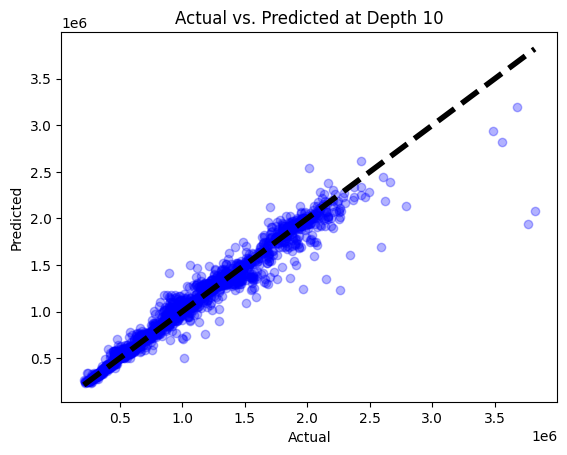

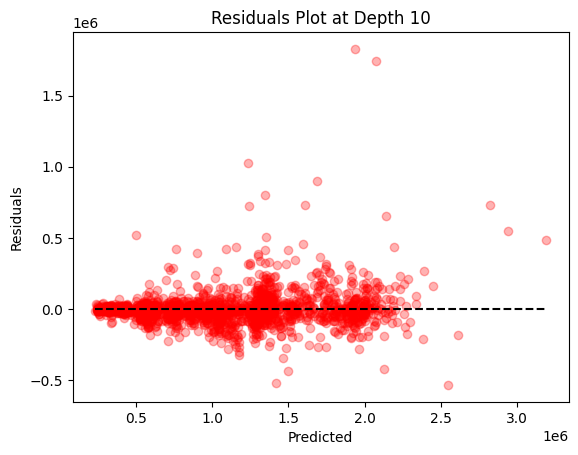

STATISTICS FOR DEPTH 11
-----------------------------------------
Test MSE: 13001167808.414015
Test sqrt of mse: 114022.66357358091
Test RMSE: 114022.66357358091
Test MAE: 58319.49877288385
Test R² score: 0.9593358510810237


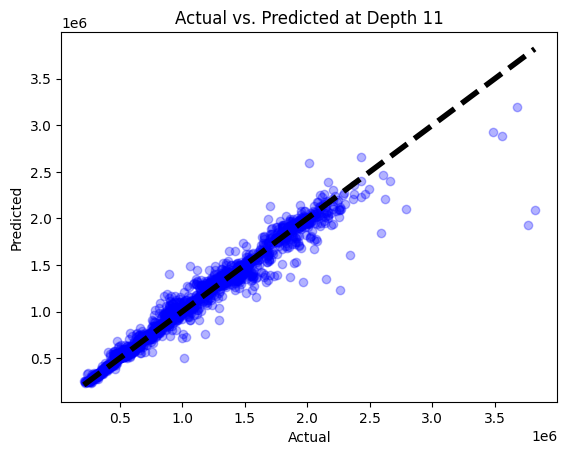

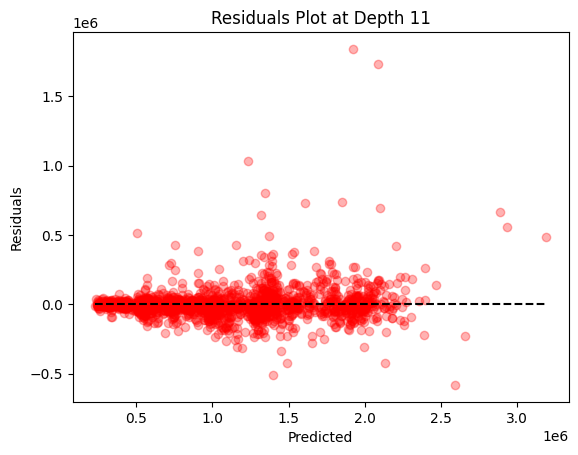

STATISTICS FOR DEPTH 12
-----------------------------------------
Test MSE: 12361188518.073425
Test sqrt of mse: 111180.88198100169
Test RMSE: 111180.88198100169
Test MAE: 55561.44525633149
Test R² score: 0.961337533818372


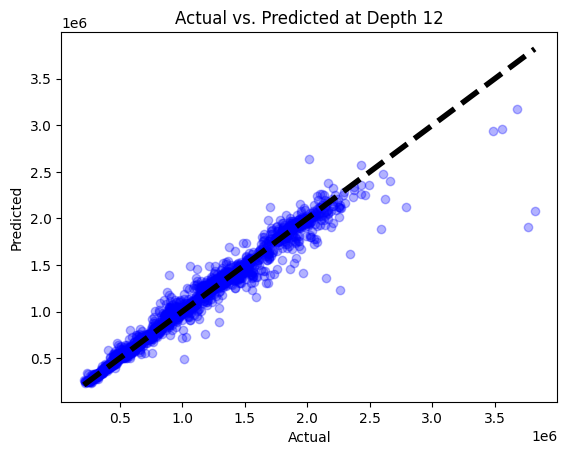

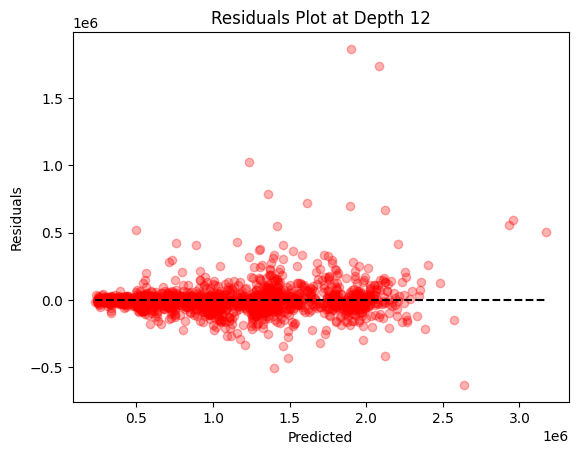

In [321]:
# Splitting the dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_test, y_test, test_size=0.3, random_state=42)

# Assuming the best depth found is between 8 to 12.

# Digging down to find the best depth
for i in range(8, 13):
    best_depth = i

    # Create the model with the specified depth
    model = RandomForestRegressor(max_depth=best_depth, n_estimators=numTrees)
    model.fit(X_train, y_train)  # Train model on the initial training set

    # Predict the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_test - y_pred))
    r2 = r2_score(y_test, y_pred)

    print("STATISTICS FOR DEPTH %i" % i)
    print("-----------------------------------------")
    print(f"Test MSE: {mse}")
    print(f"Test sqrt of mse: {math.sqrt(mse)}")
    print(f"Test RMSE: {rmse}")
    print(f"Test MAE: {mae}")
    print(f"Test R² score: {r2}")

    # Visualization of Actual vs Predicted
    plt.figure()
    plt.scatter(y_test, y_pred, alpha=0.3, color='blue')  # alpha for transparency
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Ideal line
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs. Predicted at Depth %i' % i)
    plt.show()

    # Residuals plot
    residuals = y_test - y_pred
    plt.figure()
    plt.scatter(y_pred, residuals, alpha=0.3, color='red')
    plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='black', linestyles='dashed')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residuals Plot at Depth %i' % i)
    plt.show()

Notice that most of the data looks the same, but depth 12 has a better R2 score than depth 8! (.928 vs .961)

## Evaluating Our Initial Model

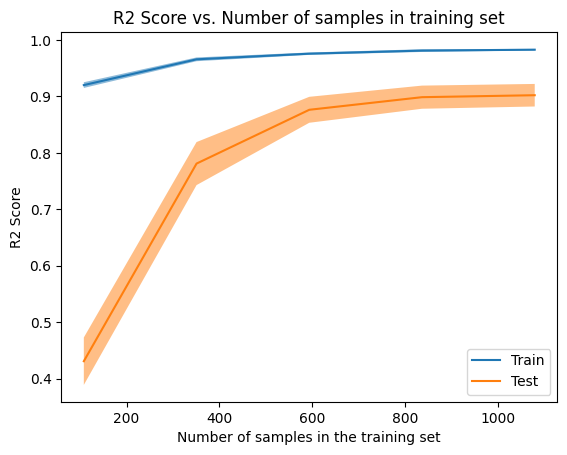

In [322]:
t_sizes, t_scores, test_scores = learning_curve(model, X_train, y_train)

display = LearningCurveDisplay(train_sizes=t_sizes, train_scores=t_scores, test_scores=test_scores, score_name = "R2 Score")
display.plot()
plt.title("R2 Score vs. Number of samples in training set")
plt.show()

Note that naturally, the R2 score of our model increases drastically when having more than 400 samples in the training set, and increases up to roughly 0.9 in our test set.

For our training set, the peak R2 score appears to be around 0.95 - 0.96.

In [323]:
# Checking out the most 'important' features in predicting weekly sales
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': standardizedDf.columns[:-1], 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df.head())

        Feature  Importance
0         Store    0.670892
5    Fuel_Price    0.191501
6           CPI    0.082603
3  Holiday_Flag    0.025617
4   Temperature    0.014899


In this case, the top 3 most impactful features are the Store, Fuel_Price, and the CPI. The Store type influences sales by reflecting varying demographics, location, and how demographics influences what products they purchase, while fuel prices impact consumer spending habits and operational costs, and changes in the Consumer Price Index affect purchasing power, collectively shaping weekly sales for the company.

# Insights and Conclusions